# Generating Similiarity Matrixes

In [14]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from statistics import mean
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt

In [15]:
import sys
sys.path.append('../../src')
from DataLoader import DataLoader

In [16]:
fileLoader = DataLoader("../config.yaml")

In [17]:
df_aimeta = fileLoader.load_data("files.df_aimeta")
df_aimeta.head(3)

/media/sz/Data/Connected_Lecturers/Opal_crosslab/raw/OPAL_ai_meta.p


,pipe:ID,pipe:file_type,ai:author,ai:revisedAuthor,ai:affilation,ai:title,ai:type,ai:keywords_ext,ai:keywords_gen,ai:keywords_dnb,ai:dewey
0,8I6sM5zapD60,pdf,"Stephan Gerhold, Marcel Beyer",[Vorname='Stephan' Familienname='Gerhold' Tite...,,Übung 3 Photogrammetrie,Aufgabenblatt,"Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, digitale Entzerrung, Resampli...","Photogrammetrie, Bildverarbeitung, Digitale En...",
1,8ZICOHBmAHyQ,pdf,"(Leerstring, da kein Autor im Dokument erwähnt...",[],,3.1 Grundlagen der Tragwerke,Skript,"Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Tragwerke, Lagerreaktionen, Gleichgewichtsbedi...","Tragwerke, Statik, Mechanik, Festigkeitslehre,...",
2,8Lfz8SAKa6k0,pdf,Robert Ringel,[Vorname='Robert' Familienname='Ringel' Titel=''],,Gedanken und Notizen zu unserem Mini-KI-Worksh...,Protokoll,"Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus...","Künstliche Intelligenz, Automatisierung, Indus...",


In [18]:
df_keywords = fileLoader.load_data("files.df_keywordlist")
df_keywords.head(3)

/media/sz/Data/Connected_Lecturers/Opal_crosslab/processed/keyword_list.p


,raw_keyword,lemma,is_gnd,gnd_link,sameAs_link,ddc_D3,perferedNames,totalItems,count,ddc_D2
0,Photogrammetrie,Photogrammetrie,True,https://d-nb.info/gnd/4184798-2,http://www.wikidata.org/entity/Q15850396,http://dewey.info/class/526.9825/,"['Terrestrische Fotogrammetrie', 'Fotogrammetr...",2.0,25,NaN
1,digitale Entzerrung,,True,https://d-nb.info/gnd/4395561-7,NaN,NaN,['Orthoprojektion'],1.0,2,NaN
2,Resamplingmethoden,Resamplingmethoden,False,NaN,NaN,NaN,NaN,NaN,2,NaN


## Preprocessing

In [19]:
# DDC-Nummern Extraktion und Validierung (optimiert)
def extract_and_validate_ddc(ddc_url):
    """
    Extrahiert und validiert DDC-Nummer aus einer URL.
    Gibt None zurück falls URL ungültig oder DDC-Nummer nicht korrekt formatiert ist.
    """
    if pd.isna(ddc_url):
        return None
    
    try:
        # Extrahiere DDC-Nummer aus URL (5. Element nach Split)
        ddc_number = ddc_url.split("/")[4]
        
        # Validiere Format: nur Ziffern und Punkte erlaubt
        if all(c.isdigit() or c == '.' for c in ddc_number):
            return ddc_number
        else:
            return None
    except (IndexError, AttributeError):
        return None

# Anwendung der optimierten Funktion auf beide DDC-Spalten
print("Extrahiere und validiere DDC-Nummern...")
df_keywords['ddc_D3_number'] = df_keywords['ddc_D3'].apply(extract_and_validate_ddc)
df_keywords['ddc_D2_number'] = df_keywords['ddc_D2'].apply(extract_and_validate_ddc)

# Kombiniere DDC-Nummern in einer Liste
df_keywords['ddc_numbers'] = df_keywords[['ddc_D3_number', 'ddc_D2_number']].apply(
    lambda row: [num for num in row if pd.notna(num)], axis=1
)

# Erstelle Labels mit Keywords und DDC-Nummern
df_keywords['ddc_label'] = df_keywords.apply(
    lambda row: [f"{row['raw_keyword']} ({num})" for num in row['ddc_numbers']], axis=1
)

print(f"DDC-Verarbeitung abgeschlossen. {len(df_keywords)} Keywords verarbeitet.")

# Zeige Ergebnisse für GND-validierte Keywords
df_keywords[df_keywords.is_gnd==True]\
    [['raw_keyword', 'perferedNames', 'ddc_D2', 'ddc_D2_number','ddc_D3', 
      'ddc_D3_number', 'ddc_numbers', 'ddc_label']].head(5)

Extrahiere und validiere DDC-Nummern...
DDC-Verarbeitung abgeschlossen. 43289 Keywords verarbeitet.
DDC-Verarbeitung abgeschlossen. 43289 Keywords verarbeitet.


,raw_keyword,perferedNames,ddc_D2,ddc_D2_number,ddc_D3,ddc_D3_number,ddc_numbers,ddc_label
0,Photogrammetrie,"['Terrestrische Fotogrammetrie', 'Fotogrammetr...",NaN,None,http://dewey.info/class/526.9825/,526.9825,[526.9825],[Photogrammetrie (526.9825)]
1,digitale Entzerrung,['Orthoprojektion'],NaN,None,NaN,None,[],[]
4,Parallelprojektion,"['Parallelprojektion', 'Orthogonale Parallelpr...",NaN,None,NaN,None,[],[]
11,Bildverarbeitung,"['Bildverarbeitung', 'Snake <Bildverarbeitung>...",http://dewey.info/class/006.42/,006.42,NaN,None,[006.42],[Bildverarbeitung (006.42)]
12,Interpolation,"['Interpolation', 'Kergin-Interpolation', 'Meh...",http://dewey.info/class/511.42/,511.42,NaN,None,[511.42],[Interpolation (511.42)]


In [20]:
# Wie viele Zeilen hat df_keywords?
print(f"Anzahl der Zeilen in df_keywords: {len(df_keywords)}")
# Wie viele Einträge haben ddc_D2_number und/ oder ddc_D2_number? Wie viele haben gar keinen DDC Wert?

ddc_d2_count = df_keywords['ddc_D2_number'].notna().sum()
ddc_d3_count = df_keywords['ddc_D3_number'].notna().sum()
ddc_both_count = df_keywords['ddc_numbers'].apply(lambda x: len(x) > 0).sum()
ddc_none_count = df_keywords['ddc_numbers'].apply(lambda x: len(x) == 0).sum()

print("=== DDC ZÄHLEN ===")
print(f"Einträge mit DDC D2: {ddc_d2_count}")
print(f"Einträge mit DDC D3: {ddc_d3_count}")
print(f"Einträge mit beiden DDCs: {ddc_both_count}")
print(f"Einträge ohne DDC: {ddc_none_count}")

Anzahl der Zeilen in df_keywords: 43289
=== DDC ZÄHLEN ===
Einträge mit DDC D2: 11428
Einträge mit DDC D3: 4609
Einträge mit beiden DDCs: 14435
Einträge ohne DDC: 28854




### df_aimeta - Analyse der DDC-Nummern

Sind diese als gültig in der Keyword-List enthalten?

In [21]:
# Keyword-Validierung und GND-Mapping
# Diese Zelle führt eine Validierung der extrahierten Keywords durch
# und erstellt Mappings zu GND-validierten Referenzen

# Schritt 1: Erstelle Mapping von Keywords zu IDs im df_keywords
print("Erstelle Keyword-zu-ID Mapping...")
keyword_to_id = {}
for idx, row in df_keywords.iterrows():
    if pd.notna(row['raw_keyword']):
        keyword = str(row['raw_keyword']).strip().lower()
        if keyword not in keyword_to_id:
            keyword_to_id[keyword] = []
        keyword_to_id[keyword].append(idx)

print(f"Keyword-Mapping erstellt: {len(keyword_to_id)} eindeutige Keywords")

# Schritt 2: Konvertiere Keyword-Strings zu ID-Listen
def parse_keywords_to_ids(keyword_string):
    """Konvertiert einen Keyword-String zu einer Liste von IDs"""
    if pd.isna(keyword_string) or keyword_string == "":
        return []
    
    # Teile Keywords auf (kommagetrennt)
    keywords = [k.strip().lower() for k in str(keyword_string).split(',')]
    ids = []
    
    for keyword in keywords:
        if keyword in keyword_to_id:
            ids.extend(keyword_to_id[keyword])
    
    return list(set(ids))  # Entferne Duplikate

# Erstelle _ids Spalten aus den Keyword-Strings
print("Konvertiere Keywords zu IDs...")
for keyword_type in ['ext', 'gen', 'dnb']:
    df_aimeta[f'ai:keywords_{keyword_type}_ids'] = df_aimeta[f'ai:keywords_{keyword_type}'].apply(parse_keywords_to_ids)

print("Keyword-zu-ID Konvertierung abgeschlossen")

# Schritt 3: Initialisierung der Validierungs-Spalten
for keyword_type in ['ext', 'dnb', 'gen']:
    if f'ai:keywords_{keyword_type}_ids_valid' not in df_aimeta.columns:
        df_aimeta[f'ai:keywords_{keyword_type}_ids_valid'] = [[] for _ in range(len(df_aimeta))]
    if f'ai:keywords_{keyword_type}_valid_ratio' not in df_aimeta.columns:
        df_aimeta[f'ai:keywords_{keyword_type}_valid_ratio'] = 0.0

# Schritt 4: Keyword-Validierung durch GND-Mapping
print("Starte GND-Validierung...")
for index, row in tqdm(df_aimeta.iterrows(), total=len(df_aimeta), desc="Validiere Keywords"):
    for keyword_type in ['ext', 'dnb', 'gen']:
        keyword_ids = row[f'ai:keywords_{keyword_type}_ids']
        valid_ids = []
        
        # Prüfe jeden Keyword-Index auf GND-Validierung
        for keyword_id in keyword_ids:
            if keyword_id < len(df_keywords):
                keyword_row = df_keywords.iloc[keyword_id]
                # Validierung basierend auf GND-Status und Preferred Names
                if (keyword_row['is_gnd'] == True and 
                    pd.notna(keyword_row['perferedNames']) and 
                    len(str(keyword_row['perferedNames']).strip()) > 0):
                    valid_ids.append(keyword_id)
        
        # Speichere validierte IDs und berechne Ratio
        df_aimeta.at[index, f'ai:keywords_{keyword_type}_ids_valid'] = valid_ids
        
        # Berechne Validierungs-Ratio
        total_keywords = len(keyword_ids)
        valid_keywords = len(valid_ids)
        ratio = valid_keywords / total_keywords if total_keywords > 0 else 0.0
        df_aimeta.at[index, f'ai:keywords_{keyword_type}_valid_ratio'] = ratio

# Schritt 5: Zusammenführung aller validierten DDC-Keywords
df_aimeta['all_ddc_valid_ids'] = df_aimeta['ai:keywords_ext_ids_valid'] + df_aimeta['ai:keywords_dnb_ids_valid'] + df_aimeta['ai:keywords_gen_ids_valid']
#df_aimeta['all_ddc_valid_ids'] = df_aimeta['ai:keywords_dnb_ids_valid']

# Duplikate entfernen
#df_aimeta['all_ddc_valid_ids'] = df_aimeta['all_ddc_valid_ids'].apply(lambda x: list(set(x)))

# Anzahl der validierten Keywords zählen
df_aimeta['ddc_valid_count'] = df_aimeta['all_ddc_valid_ids'].apply(lambda x: len(x))

print("Validierung abgeschlossen!")

# Ausgabe der Ergebnisse
df_aimeta[['pipe:ID',
       'ai:keywords_ext_ids_valid', 'ai:keywords_ext_valid_ratio',
       'ai:keywords_dnb_ids_valid', 'ai:keywords_dnb_valid_ratio',
       'ai:keywords_gen_ids_valid', 'ai:keywords_gen_valid_ratio', 
       "all_ddc_valid_ids", "ddc_valid_count"]].head(3)

Erstelle Keyword-zu-ID Mapping...
Keyword-Mapping erstellt: 42229 eindeutige Keywords
Konvertiere Keywords zu IDs...
Keyword-zu-ID Konvertierung abgeschlossen
Starte GND-Validierung...
Keyword-Mapping erstellt: 42229 eindeutige Keywords
Konvertiere Keywords zu IDs...
Keyword-zu-ID Konvertierung abgeschlossen
Starte GND-Validierung...


Validiere Keywords: 100%|██████████| 4548/4548 [00:06<00:00, 674.16it/s]


Validierung abgeschlossen!


,pipe:ID,ai:keywords_ext_ids_valid,ai:keywords_ext_valid_ratio,ai:keywords_dnb_ids_valid,ai:keywords_dnb_valid_ratio,ai:keywords_gen_ids_valid,ai:keywords_gen_valid_ratio,all_ddc_valid_ids,ddc_valid_count
0,8I6sM5zapD60,"[0, 1, 4, 14]",0.333333,"[0, 1, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21,...",0.9375,"[0, 1, 4, 11, 12, 14]",0.545455,"[0, 1, 4, 14, 0, 1, 11, 12, 14, 15, 16, 17, 18...",25
1,8ZICOHBmAHyQ,"[33, 34, 25, 30]",0.363636,"[40, 41, 43, 44, 45, 46, 47, 50, 51, 25, 30]",0.6875,"[33, 36, 39, 25]",0.363636,"[33, 34, 25, 30, 40, 41, 43, 44, 45, 46, 47, 5...",19
2,8Lfz8SAKa6k0,"[58, 52, 53, 54, 55, 56, 3706, 59, 60]",0.750000,"[67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 52, 5...",0.9375,"[65, 58, 52, 53, 56, 3706, 60, 62]",0.666667,"[58, 52, 53, 54, 55, 56, 3706, 59, 60, 67, 68,...",32


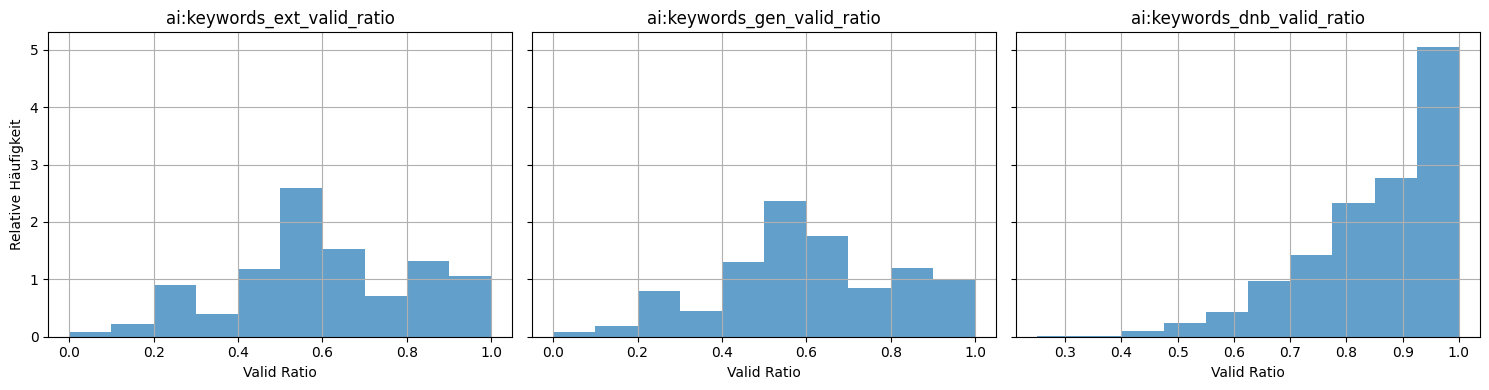

In [22]:
# Liste der Spalten für die Histogramme
columns_to_plot = [
    'ai:keywords_ext_valid_ratio',
    'ai:keywords_gen_valid_ratio', 
    'ai:keywords_dnb_valid_ratio'
]

# Erstelle Subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Erstelle Histogramme mit relativen Häufigkeiten
for i, column in enumerate(columns_to_plot):
    df_aimeta[column].hist(ax=axes[i], bins=10, density=True, alpha=0.7)
    axes[i].set_title(column)
    axes[i].set_ylabel('Relative Häufigkeit' if i == 0 else '')
    axes[i].set_xlabel('Valid Ratio')

plt.tight_layout()
plt.savefig("valid_ratio_histograms.png")
plt.show()

In [23]:
# Erstelle neuen DataFrame mit DDC Labels als Integer-Werte für alle df_aimeta Materialien

def extract_ddc_numbers_as_int(keyword_ids, df_keywords, ddc_column):
    """
    Extrahiert DDC-Nummern als Integer-Werte für eine Liste von Keyword-IDs
    Behält Duplikate bei, falls sie auftreten
    """
    ddc_numbers = []  # Verwende Liste statt Set, um Duplikate zu behalten
    
    for keyword_id in keyword_ids:
        if keyword_id < len(df_keywords):
            keyword_row = df_keywords.iloc[keyword_id]
            ddc_value = keyword_row[ddc_column]
            
            if pd.notna(ddc_value):
                try:
                    # Konvertiere DDC-Nummer zu Integer (Hauptklasse)
                    ddc_int = int(float(ddc_value.split('.')[0]))
                    ddc_numbers.append(ddc_int)  # Füge hinzu ohne Duplikat-Prüfung
                except (ValueError, AttributeError, IndexError):
                    continue
    
    return ddc_numbers

print("Erstelle DataFrame mit DDC Labels als Integer-Werte...")

# Initialisiere Listen für den neuen DataFrame
material_ids = []
ddc_d2_lists = []
ddc_d3_lists = []
ddc_d2_unique_counts = []
ddc_d3_unique_counts = []
ddc_combined_lists = []

# Verarbeite jedes Material in df_aimeta
for index, row in tqdm(df_aimeta.iterrows(), total=len(df_aimeta), desc="Verarbeite Materialien"):
    material_id = row['pipe:ID']
    material_ids.append(material_id)
    
    # Sammle alle Keyword-IDs für dieses Material
    all_keyword_ids = []
    for keyword_type in ['ext', 'gen', 'dnb']:
        keyword_ids = row[f'ai:keywords_{keyword_type}_ids']
        all_keyword_ids.extend(keyword_ids)
    
    # Entferne Duplikate aus Keyword-IDs (aber behalte DDC-Duplikate)
    all_keyword_ids = list(set(all_keyword_ids))
    
    # Extrahiere DDC_D2 Nummern als Integer
    ddc_d2_ints = extract_ddc_numbers_as_int(all_keyword_ids, df_keywords, 'ddc_D2_number')
    ddc_d2_lists.append(ddc_d2_ints)
    ddc_d2_unique_counts.append(len(ddc_d2_ints))
    
    # Extrahiere DDC_D3 Nummern als Integer
    ddc_d3_ints = extract_ddc_numbers_as_int(all_keyword_ids, df_keywords, 'ddc_D3_number')
    ddc_d3_lists.append(ddc_d3_ints)
    ddc_d3_unique_counts.append(len(ddc_d3_ints))
    
    # Kombiniere beide Listen (behalte alle Duplikate)
    combined_ddcs = ddc_d2_ints + ddc_d3_ints
    ddc_combined_lists.append(combined_ddcs)

# Erstelle neuen DataFrame
df_ddc_labels = pd.DataFrame({
    'material_id': material_ids,
    'ddc_d2_labels': ddc_d2_lists,
    'ddc_d3_labels': ddc_d3_lists,
    'ddc_combined_labels': ddc_combined_lists,
    'ddc_d2_count': ddc_d2_unique_counts,
    'ddc_d3_count': ddc_d3_unique_counts,
    'ddc_total_count': [len(combined) for combined in ddc_combined_lists]
})

print(f"DataFrame erstellt mit {len(df_ddc_labels)} Materialien")

df_ddc_labels.head(3)

Erstelle DataFrame mit DDC Labels als Integer-Werte...


Verarbeite Materialien: 100%|██████████| 4548/4548 [00:07<00:00, 605.10it/s]

DataFrame erstellt mit 4548 Materialien


,material_id,ddc_d2_labels,ddc_d3_labels,ddc_combined_labels,ddc_d2_count,ddc_d3_count,ddc_total_count
0,8I6sM5zapD60,"[6, 511, 519, 6, 690, 550, 526, 526, 621]","[526, 720, 720, 526, 6]","[6, 511, 519, 6, 690, 550, 526, 526, 621, 526,...",9,5,14
1,8ZICOHBmAHyQ,"[620, 624, 620, 620, 624, 671]","[624, 618, 531, 531, 621, 531]","[620, 624, 620, 620, 624, 671, 624, 618, 531, ...",6,6,12
2,8Lfz8SAKa6k0,"[338, 6, 6, 658, 6, 6, 6, 153, 230, 371]","[338, 153, 6, 519, 6, 153, 294, 6]","[338, 6, 6, 658, 6, 6, 6, 153, 230, 371, 338, ...",10,8,18


## Vorbereitung der Ähnlichkeitsberechnung

### Berechne eine Ähnlichkeit anhand der DDC Nummern

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Funktion: Vektor aus Ganzzahl-DDCs
def make_ddc_vector(codes, length=1000):
    vec = np.zeros(length)
    for code in codes:
        idx = int(code)  # Ganzzahlanteil
        if 0 <= idx < length:
            vec[idx] += 1
            #vec[idx] = 1  # Setze den Wert auf 1, ohne die Häufigkeit zu zählen
    return vec

# Vektoren generieren
df_ddc_labels["ddc_vector"] = df_ddc_labels["ddc_combined_labels"].apply(make_ddc_vector)

# Vektoren zusammenführen in Matrix
X = np.vstack(df_ddc_labels["ddc_vector"].values)

# Finden, an welchen Spaltenindexstellen überall 0 steht
all_zero_indices = np.all(X == 0, axis=0)  # ergibt ein Array der Länge 1000 (True/False)
X_cleaned = X[:, ~all_zero_indices]
print(X_cleaned.shape)

# Cosinus-Ähnlichkeit
cos_similarity_matrix = cosine_similarity(X)

# Optional: Als DataFrame anzeigen
cos_similarity_df = pd.DataFrame(cos_similarity_matrix, index=df_ddc_labels["material_id"], columns=df_ddc_labels["material_id"])
processed_data_folder = fileLoader.config_manager.get("folder_structure.processed_data_folder")
cos_similarity_df.to_pickle(Path(processed_data_folder) / "cosine_keywords_similaritiy.p")
cos_similarity_df

(4548, 467)


material_id,8I6sM5zapD60,8ZICOHBmAHyQ,8Lfz8SAKa6k0,3ztCv-WpxJ4U,6mOhjfscZK2A,1eteONeHL82Y,4ko3QE49jYdg,1mjbqKfwSW7U,1BruMQFjEIRY,1Qhnsa15Gixs,...,12QgNIYLxydAY,12IVVtroo82Uk,127HM_Da6VkYA,12jbMf7CPG0ck,11ONBt_S6XLVM,8Qx2WQd_ANdI,7rwytM7w-8HE,8MBQRpA2XSQU,10MPMUvFFT_H0,11zdGfDSphJpg
material_id,,,,,,,,,,,,,,,,,,,,,
8I6sM5zapD60,1.000000,0.000000,0.506370,0.000000,0.000000,0.000000,0.065372,0.000000,0.307692,0.000000,...,0.524142,0.339683,0.496139,0.667124,0.000000,0.000000,0.134535,0.000000,0.000000,0.000000
8ZICOHBmAHyQ,0.000000,1.000000,0.000000,0.000000,0.540062,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8Lfz8SAKa6k0,0.506370,0.000000,1.000000,0.064550,0.052705,0.129099,0.000000,0.081650,0.607644,0.044281,...,0.000000,0.000000,0.000000,0.243975,0.097590,0.000000,0.354246,0.000000,0.000000,0.173205
3ztCv-WpxJ4U,0.000000,0.000000,0.064550,1.000000,0.000000,0.250000,0.000000,0.632456,0.098058,0.085749,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.085749,0.000000,0.000000,0.000000
6mOhjfscZK2A,0.000000,0.540062,0.052705,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070014,0.204124,0.000000,0.091287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8Qx2WQd_ANdI,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.114332,...,0.000000,0.096225,0.105409,0.000000,0.251976,1.000000,0.114332,0.000000,0.136083,0.000000
7rwytM7w-8HE,0.134535,0.000000,0.354246,0.085749,0.070014,0.000000,0.000000,0.108465,0.201802,0.294118,...,0.000000,0.000000,0.000000,0.064820,0.000000,0.114332,1.000000,0.000000,0.000000,0.000000
8MBQRpA2XSQU,0.000000,0.000000,0.000000,0.000000,0.204124,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.188982,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [25]:
def jaccard_similarity(list1, list2):
    # Umwandlung der Listen in Mengen
    set1 = set(list1)
    set2 = set(list2)
    
    # Berechnung der Schnittmenge und der Vereinigung
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    # Berechnung der Jaccard-Ähnlichkeit
    if union == 0:
        return 0.0  # Vermeidung von Division durch Null
    else:
        return intersection / union

# Berechnung der Jaccard-Ähnlichkeit über allen DDC-Listen
jaccard_matrix = np.zeros((len(df_ddc_labels), len(df_ddc_labels)))
for i in tqdm(range(len(df_ddc_labels)), desc="Berechnung der Jaccard-Ähnlichkeit"):
    for j in range(i + 1, len(df_ddc_labels)):
        jaccard_matrix[i, j] = jaccard_similarity(df_ddc_labels.iloc[i]['ddc_combined_labels'], df_ddc_labels.iloc[j]['ddc_combined_labels'])
        jaccard_matrix[j, i] = jaccard_matrix[i, j]  # Symmetrisch

# Optional: Als DataFrame anzeigen

jaccard_similarity_df = pd.DataFrame(jaccard_matrix, index=df_ddc_labels["material_id"], columns=df_ddc_labels["material_id"])
processed_data_folder = fileLoader.config_manager.get("folder_structure.processed_data_folder")
jaccard_similarity_df.to_pickle(Path(processed_data_folder) / "jaccard_keyword_similarity.p")

Berechnung der Jaccard-Ähnlichkeit: 100%|██████████| 4548/4548 [09:30<00:00,  7.97it/s] 



In [33]:

def weighted_jaccard_similarity(list1, list2):
    """
    Gewichtete Jaccard-Ähnlichkeit basierend auf Häufigkeiten der DDC-Nummern
    """
    from collections import Counter
    
    if not list1 and not list2:
        return 1.0
    if not list1 or not list2:
        return 0.0
    
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    
    # Alle einzigartigen DDC-Nummern
    all_ddcs = set(list1 + list2)
    
    intersection_weight = 0
    union_weight = 0
    
    for ddc in all_ddcs:
        count1 = counter1.get(ddc, 0)
        count2 = counter2.get(ddc, 0)
        
        # Intersection: Minimum der Häufigkeiten
        intersection_weight += min(count1, count2)
        # Union: Maximum der Häufigkeiten  
        union_weight += max(count1, count2)
    
    return intersection_weight / union_weight if union_weight > 0 else 0.0

def tfidf_cosine_similarity(list1, list2, doc_frequencies, total_docs):
    """
    TF-IDF gewichtete Cosinus-Ähnlichkeit
    Seltene DDC-Nummern bekommen höheres Gewicht
    """
    from collections import Counter
    import math
    
    if not list1 and not list2:
        return 1.0
    if not list1 or not list2:
        return 0.0
    
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    
    # Alle DDC-Nummern in beiden Listen
    all_ddcs = set(list1 + list2)
    
    # TF-IDF Vektoren berechnen
    vector1 = {}
    vector2 = {}
    
    for ddc in all_ddcs:
        # Term Frequency
        tf1 = counter1.get(ddc, 0) / len(list1) if list1 else 0
        tf2 = counter2.get(ddc, 0) / len(list2) if list2 else 0
        
        # Inverse Document Frequency
        df = doc_frequencies.get(ddc, 1)  # Dokumente mit dieser DDC-Nummer
        idf = math.log(total_docs / df) if df > 0 else 0
        
        # TF-IDF Gewichtung
        vector1[ddc] = tf1 * idf
        vector2[ddc] = tf2 * idf
    
    # Cosinus-Ähnlichkeit berechnen
    dot_product = sum(vector1[ddc] * vector2[ddc] for ddc in all_ddcs)
    norm1 = math.sqrt(sum(v**2 for v in vector1.values()))
    norm2 = math.sqrt(sum(v**2 for v in vector2.values()))
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

def overlap_coefficient(list1, list2):
    """
    Overlap-Koeffizient (Szymkiewicz-Simpson Index)
    Gut für unterschiedlich große Listen
    """
    set1 = set(list1)
    set2 = set(list2)
    
    if not set1 and not set2:
        return 1.0
    if not set1 or not set2:
        return 0.0
    
    intersection = len(set1.intersection(set2))
    min_size = min(len(set1), len(set2))
    
    return intersection / min_size

def dice_coefficient(list1, list2):
    """
    Dice-Koeffizient (Sørensen-Dice Index)
    Gibt doppeltes Gewicht auf Überschneidungen
    """
    set1 = set(list1)
    set2 = set(list2)
    
    if not set1 and not set2:
        return 1.0
    if not set1 or not set2:
        return 0.0
    
    intersection = len(set1.intersection(set2))
    return (2 * intersection) / (len(set1) + len(set2))



In [27]:
# BERECHNUNG DER DOKUMENTFREQUENZEN FÜR TF-IDF
print("Berechne Dokumentfrequenzen für TF-IDF...")

doc_frequencies = {}
total_docs = len(df_ddc_labels)

for _, row in df_ddc_labels.iterrows():
    unique_ddcs = set(row['ddc_combined_labels'])
    for ddc in unique_ddcs:
        doc_frequencies[ddc] = doc_frequencies.get(ddc, 0) + 1

print(f"Dokumentfrequenzen für {len(doc_frequencies)} einzigartige DDC-Nummern berechnet")

# VERGLEICH VERSCHIEDENER ÄHNLICHKEITSMASSE
print("\nTeste verschiedene Ähnlichkeitsmaße mit Beispieldaten...")

# Wähle einige Beispiel-Materialien für Vergleich
sample_indices = [0, 1, 10, 50, 100]
sample_materials = df_ddc_labels.iloc[sample_indices]

print("\nVergleich der Ähnlichkeitsmaße für erste 5 Materialien:")
print("Material 1:", sample_materials.iloc[0]['ddc_combined_labels'][:5])
print("Material 2:", sample_materials.iloc[1]['ddc_combined_labels'][:5])

list1 = sample_materials.iloc[0]['ddc_combined_labels']
list2 = sample_materials.iloc[1]['ddc_combined_labels']

print(f"\nÄhnlichkeitsvergleich zwischen Material {sample_materials.iloc[0]['material_id']} und {sample_materials.iloc[1]['material_id']}:")
print(f"Standard Jaccard: {jaccard_similarity(list1, list2):.4f}")
print(f"Weighted Jaccard: {weighted_jaccard_similarity(list1, list2):.4f}")
print(f"TF-IDF Cosine: {tfidf_cosine_similarity(list1, list2, doc_frequencies, total_docs):.4f}")
print(f"Overlap Coefficient: {overlap_coefficient(list1, list2):.4f}")
print(f"Dice Coefficient: {dice_coefficient(list1, list2):.4f}")

# ANALYSE DER DATENVERTEILUNG
print(f"\nDatenanalyse:")
print(f"Durchschnittliche Anzahl DDC-Nummern pro Dokument: {np.mean([len(labels) for labels in df_ddc_labels['ddc_combined_labels']]):.2f}")
print(f"Median Anzahl DDC-Nummern pro Dokument: {np.median([len(labels) for labels in df_ddc_labels['ddc_combined_labels']]):.2f}")
print(f"Max Anzahl DDC-Nummern pro Dokument: {max([len(labels) for labels in df_ddc_labels['ddc_combined_labels']])}")

# Dokumente ohne DDC-Nummern
empty_docs = sum(1 for labels in df_ddc_labels['ddc_combined_labels'] if len(labels) == 0)
print(f"Dokumente ohne DDC-Nummern: {empty_docs} ({empty_docs/total_docs*100:.1f}%)")

# Häufigste DDC-Nummern
from collections import Counter
all_ddcs = []
for labels in df_ddc_labels['ddc_combined_labels']:
    all_ddcs.extend(labels)

ddc_counter = Counter(all_ddcs)
print(f"\nHäufigste DDC-Nummern:")
for ddc, count in ddc_counter.most_common(10):
    print(f"  {ddc}: {count} Dokumente ({count/total_docs*100:.1f}%)")

Berechne Dokumentfrequenzen für TF-IDF...
Dokumentfrequenzen für 515 einzigartige DDC-Nummern berechnet

Teste verschiedene Ähnlichkeitsmaße mit Beispieldaten...

Vergleich der Ähnlichkeitsmaße für erste 5 Materialien:
Material 1: [6, 511, 519, 6, 690]
Material 2: [620, 624, 620, 620, 624]

Ähnlichkeitsvergleich zwischen Material 8I6sM5zapD60 und 8ZICOHBmAHyQ:
Standard Jaccard: 0.0769
Weighted Jaccard: 0.0400
TF-IDF Cosine: 0.0068
Overlap Coefficient: 0.1667
Dice Coefficient: 0.1429

Datenanalyse:
Durchschnittliche Anzahl DDC-Nummern pro Dokument: 15.75
Median Anzahl DDC-Nummern pro Dokument: 15.00
Max Anzahl DDC-Nummern pro Dokument: 34
Dokumente ohne DDC-Nummern: 0 (0.0%)

Häufigste DDC-Nummern:
  621: 3842 Dokumente (84.5%)
  5: 3596 Dokumente (79.1%)
  371: 3422 Dokumente (75.2%)
  4: 3194 Dokumente (70.2%)
  658: 2616 Dokumente (57.5%)
  519: 1656 Dokumente (36.4%)
  25: 1638 Dokumente (36.0%)
  6: 1538 Dokumente (33.8%)
  511: 1485 Dokumente (32.7%)
  302: 1444 Dokumente (31.8%)


In [28]:
# BERECHNUNG VERBESSERTER ÄHNLICHKEITSMATRIZEN

def calculate_similarity_matrix(similarity_function, name, **kwargs):
    """Helper function to calculate similarity matrix with progress bar"""
    print(f"\nBerechne {name} Ähnlichkeitsmatrix...")
    
    matrix = np.zeros((len(df_ddc_labels), len(df_ddc_labels)))
    np.fill_diagonal(matrix, 1.0)  # Diagonale = 1.0
    
    for i in tqdm(range(len(df_ddc_labels)), desc=f"Berechnung {name}"):
        for j in range(i + 1, len(df_ddc_labels)):
            list1 = df_ddc_labels.iloc[i]['ddc_combined_labels']
            list2 = df_ddc_labels.iloc[j]['ddc_combined_labels']
            
            if similarity_function.__name__ == 'tfidf_cosine_similarity':
                similarity = similarity_function(list1, list2, doc_frequencies, total_docs)
            else:
                similarity = similarity_function(list1, list2)
            
            matrix[i, j] = similarity
            matrix[j, i] = similarity  # Symmetrisch
    
    return matrix

# Berechne alle verbesserten Ähnlichkeitsmatrizen
print("Starte Berechnung verbesserter Ähnlichkeitsmatrizen...")

# 1. Weighted Jaccard
weighted_jaccard_matrix = calculate_similarity_matrix(weighted_jaccard_similarity, "Weighted Jaccard")

# 2. TF-IDF Cosine
tfidf_cosine_matrix = calculate_similarity_matrix(tfidf_cosine_similarity, "TF-IDF Cosine")

# 3. Overlap Coefficient
overlap_matrix = calculate_similarity_matrix(overlap_coefficient, "Overlap Coefficient")

# 4. Dice Coefficient
dice_matrix = calculate_similarity_matrix(dice_coefficient, "Dice Coefficient")

# Erstelle DataFrames
material_ids = df_ddc_labels["material_id"]

weighted_jaccard_df = pd.DataFrame(weighted_jaccard_matrix, index=material_ids, columns=material_ids)
tfidf_cosine_df = pd.DataFrame(tfidf_cosine_matrix, index=material_ids, columns=material_ids)
overlap_df = pd.DataFrame(overlap_matrix, index=material_ids, columns=material_ids)
dice_df = pd.DataFrame(dice_matrix, index=material_ids, columns=material_ids)

print("\nAlle verbesserten Ähnlichkeitsmatrizen berechnet!")

# VERGLEICH DER ERGEBNISSE
print("\nVergleich der Ähnlichkeitsverteilungen:")

# Extrahiere obere Dreiecksmatrix (ohne Diagonale) für Statistiken
def get_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

original_jaccard_upper = get_upper_triangle(jaccard_matrix)
weighted_jaccard_upper = get_upper_triangle(weighted_jaccard_matrix) 
tfidf_cosine_upper = get_upper_triangle(tfidf_cosine_matrix)
overlap_upper = get_upper_triangle(overlap_matrix)
dice_upper = get_upper_triangle(dice_matrix)

methods = {
    "Original Jaccard": original_jaccard_upper,
    "Weighted Jaccard": weighted_jaccard_upper,
    "TF-IDF Cosine": tfidf_cosine_upper,
    "Overlap Coefficient": overlap_upper,
    "Dice Coefficient": dice_upper
}

print(f"{'Methode':<20} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Non-Zero%':<10}")
print("-" * 70)

for name, values in methods.items():
    non_zero_pct = (np.count_nonzero(values) / len(values)) * 100
    print(f"{name:<20} {np.mean(values):<8.4f} {np.std(values):<8.4f} {np.min(values):<8.4f} {np.max(values):<8.4f} {non_zero_pct:<10.1f}")

print(f"\nInterpretation:")
print(f"- Höhere Standardabweichung = bessere Differenzierung")
print(f"- Niedrigerer Non-Zero% = sparsere, selektivere Ähnlichkeiten")
print(f"- TF-IDF gewichtet seltene DDC-Nummern höher")
print(f"- Overlap gut für unterschiedlich große Dokumentgrößen")

Starte Berechnung verbesserter Ähnlichkeitsmatrizen...

Berechne Weighted Jaccard Ähnlichkeitsmatrix...


Berechnung Weighted Jaccard: 100%|██████████| 4548/4548 [13:34<00:00,  5.58it/s] 



Berechne TF-IDF Cosine Ähnlichkeitsmatrix...


Berechnung TF-IDF Cosine: 100%|██████████| 4548/4548 [15:34<00:00,  4.87it/s] 



Berechne Overlap Coefficient Ähnlichkeitsmatrix...


Berechnung Overlap Coefficient: 100%|██████████| 4548/4548 [09:55<00:00,  7.64it/s] 



Berechne Dice Coefficient Ähnlichkeitsmatrix...


Berechnung Dice Coefficient: 100%|██████████| 4548/4548 [08:57<00:00,  8.46it/s] 



Alle verbesserten Ähnlichkeitsmatrizen berechnet!

Vergleich der Ähnlichkeitsverteilungen:
Methode              Mean     Std      Min      Max      Non-Zero% 
----------------------------------------------------------------------
Original Jaccard     0.0532   0.0804   0.0000   1.0000   45.9      
Weighted Jaccard     0.0402   0.0706   0.0000   1.0000   45.9      
TF-IDF Cosine        0.0597   0.1239   0.0000   1.0000   45.9      
Overlap Coefficient  0.1180   0.1670   0.0000   1.0000   45.9      
Dice Coefficient     0.0914   0.1267   0.0000   1.0000   45.9      

Interpretation:
- Höhere Standardabweichung = bessere Differenzierung
- Niedrigerer Non-Zero% = sparsere, selektivere Ähnlichkeiten
- TF-IDF gewichtet seltene DDC-Nummern höher
- Overlap gut für unterschiedlich große Dokumentgrößen


In [ ]:
def hierarchical_ddc_distance(ddc1, ddc2):
    """
    Berechnet die hierarchische Distanz zwischen zwei DDC-Nummern basierend auf der Baumstruktur.
    
    DDC-Hierarchie:
    - Hauptklasse (z.B. 100): Oberste Ebene
    - Unterklasse (z.B. 150): Zweite Ebene  
    - Spezialklasse (z.B. 152): Dritte Ebene
    
    Distanz basiert auf der Anzahl der Ebenen, die übereinstimmen.
    """
    if ddc1 == ddc2:
        return 0.0  # Identische DDC-Nummern
    
    # Konvertiere zu Strings für Vergleich
    str1, str2 = str(ddc1), str(ddc2)
    
    # Bestimme Hierarchieebenen basierend auf DDC-Struktur
    # DDC-Hauptklassen: 000-999 (alle 3-stelligen Zahlen)
    main_class1 = int(str1[0]) * 100  # Erste Stelle * 100 (z.B. 1xx = 100er Bereich)
    main_class2 = int(str2[0]) * 100
    
    sub_class1 = int(str1[:2]) * 10   # Erste zwei Stellen * 10 (z.B. 15x = 150er Bereich)
    sub_class2 = int(str2[:2]) * 10
    
    # Vollständige Klasse
    full_class1 = ddc1
    full_class2 = ddc2
    
    # Hierarchische Ähnlichkeit berechnen
    if main_class1 != main_class2:
        # Verschiedene Hauptklassen: maximale Distanz
        return 1.0
    elif sub_class1 != sub_class2:
        # Gleiche Hauptklasse, verschiedene Unterklassen: mittlere Distanz
        return 0.6
    elif full_class1 != full_class2:
        # Gleiche Unter-, verschiedene Spezialklassen: geringe Distanz
        return 0.3
    else:
        # Identisch (sollte nicht erreicht werden)
        return 0.0

def hierarchical_similarity_sets(set1, set2):
    """
    Berechnet die hierarchische Ähnlichkeit zwischen zwei Sets von DDC-Nummern.
    Verwendet den minimalen hierarchischen Abstand zwischen allen Kombinationen.
    """
    if len(set1) == 0 and len(set2) == 0:
        return 1.0  # Beide leer = vollständig ähnlich
    if len(set1) == 0 or len(set2) == 0:
        return 0.0  # Einer leer = keine Ähnlichkeit
    
    # Berechne alle paarweisen Distanzen
    distances = []
    for ddc1 in set1:
        for ddc2 in set2:
            distances.append(hierarchical_ddc_distance(ddc1, ddc2))
    
    # Verwende den minimalen Abstand (beste Übereinstimmung)
    min_distance = min(distances)
    
    # Konvertiere Distanz zu Ähnlichkeit (1 - Distanz)
    return 1.0 - min_distance

def hierarchical_similarity_average(list1, list2):
    """
    Berechnet die durchschnittliche hierarchische Ähnlichkeit zwischen zwei Listen von DDC-Nummern.
    Berücksichtigt alle Elemente und deren Häufigkeiten.
    """
    if len(list1) == 0 and len(list2) == 0:
        return 1.0
    if len(list1) == 0 or len(list2) == 0:
        return 0.0
    
    # Berechne gewichtete Ähnlichkeit basierend auf Häufigkeiten
    from collections import Counter
    counter1 = Counter(list1)
    counter2 = Counter(list2)
    
    # Alle einzigartigen DDC-Nummern
    all_ddcs = set(list1 + list2)
    
    similarity_sum = 0.0
    weight_sum = 0.0
    
    for ddc1 in counter1:
        for ddc2 in counter2:
            # Gewicht basierend auf Häufigkeiten
            weight = counter1[ddc1] * counter2[ddc2]
            # Hierarchische Ähnlichkeit
            sim = 1.0 - hierarchical_ddc_distance(ddc1, ddc2)
            
            similarity_sum += weight * sim
            weight_sum += weight
    
    if weight_sum == 0:
        return 0.0
    
    return similarity_sum / weight_sum

Hierarchische Ähnlichkeitsfunktionen definiert
- hierarchical_ddc_distance: Berechnet Distanz zwischen zwei DDC-Nummern
- hierarchical_similarity_sets: Minimale Distanz zwischen Sets
- hierarchical_similarity_average: Gewichtete durchschnittliche Ähnlichkeit


In [31]:
# Berechnung der hierarchischen Ähnlichkeitsmatrix
print("Berechne hierarchische Ähnlichkeitsmatrix...")

# Initialisiere Matrix
hierarchical_matrix = np.zeros((len(df_ddc_labels), len(df_ddc_labels)))

# Fülle Diagonale mit 1.0 (Material mit sich selbst)
np.fill_diagonal(hierarchical_matrix, 1.0)

# Berechne Ähnlichkeiten für alle Paare
for i in tqdm(range(len(df_ddc_labels)), desc="Berechnung der hierarchischen Ähnlichkeit"):
    for j in range(i + 1, len(df_ddc_labels)):
        # Verwende die durchschnittliche hierarchische Ähnlichkeit
        similarity = hierarchical_similarity_average(
            df_ddc_labels.iloc[i]['ddc_combined_labels'], 
            df_ddc_labels.iloc[j]['ddc_combined_labels']
        )
        hierarchical_matrix[i, j] = similarity
        hierarchical_matrix[j, i] = similarity  # Symmetrisch

# Erstelle DataFrame
hierarchical_df = pd.DataFrame(
    hierarchical_matrix, 
    index=df_ddc_labels["material_id"], 
    columns=df_ddc_labels["material_id"]
)

hierarchical_df.head(3)

Berechne hierarchische Ähnlichkeitsmatrix...


Berechnung der hierarchischen Ähnlichkeit: 100%|██████████| 4548/4548 [22:13<00:00,  3.41it/s] 


material_id,8I6sM5zapD60,8ZICOHBmAHyQ,8Lfz8SAKa6k0,3ztCv-WpxJ4U,6mOhjfscZK2A,1eteONeHL82Y,4ko3QE49jYdg,1mjbqKfwSW7U,1BruMQFjEIRY,1Qhnsa15Gixs,...,12QgNIYLxydAY,12IVVtroo82Uk,127HM_Da6VkYA,12jbMf7CPG0ck,11ONBt_S6XLVM,8Qx2WQd_ANdI,7rwytM7w-8HE,8MBQRpA2XSQU,10MPMUvFFT_H0,11zdGfDSphJpg
material_id,,,,,,,,,,,,,,,,,,,,,
8I6sM5zapD60,1.000000,0.171429,0.143254,0.022222,0.148980,0.102041,0.191270,0.015126,0.100000,0.015546,...,0.197959,0.153896,0.226190,0.242208,0.017857,0.036607,0.024224,0.210440,0.208673,0.089286
8ZICOHBmAHyQ,0.171429,1.000000,0.155556,0.033333,0.264286,0.142857,0.077778,0.005882,0.080952,0.005882,...,0.071429,0.088636,0.113889,0.252273,0.037500,0.031250,0.040217,0.138462,0.157143,0.187500
8Lfz8SAKa6k0,0.143254,0.155556,1.000000,0.055556,0.109524,0.131746,0.050617,0.052614,0.125926,0.072222,...,0.030159,0.050505,0.050000,0.153030,0.114583,0.035069,0.142029,0.039744,0.041667,0.171759


In [32]:
processed_data_folder = fileLoader.config_manager.get("folder_structure.processed_data_folder")
hierarchical_df.to_pickle(Path(processed_data_folder) / "ddc_keyword_hierarchical_similarity.p")